In [1]:
import os
import sumolib
from routing_lib import from_sumo_to_igraph_network
from meru import get_map_shape

output_folder = './drive/MyDrive/SimulationOutputs/'

os.makedirs(output_folder, exist_ok=True)
root = os.getcwd()

/home/llemma/.local/lib/python3.8/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


In [2]:
result_dict = {}

# EXTRACTING INFO FROM THE THREE NETWORKS

for city in ['florence', 'rome', 'milan_big']:
    road_network_path = f'{root}/pattern-optimized-routes/data/{city}_road_network.net.xml'
    mobility_demand_path = f'{root}/pattern-optimized-routes/data/dict_mobility_demand_{city}.json'

    road_network = sumolib.net.readNet(road_network_path, withInternal=False)
    G = from_sumo_to_igraph_network(road_network)
    
    # Raw Shape of network location
    map_shape = get_map_shape(G)

    # Projecting on Italy: EPSG:3004 is centered on Italy
    area_km2 = map_shape.to_crs(epsg=3004).geometry.area.iloc[0] / 10**6
    
    result_dict[city] = (len(road_network.getNodes()), len(road_network.getEdges()), sum(G.es['length']), area_km2)

# Get RoadNetworks Info

In [3]:
import pandas as pd

df = pd.DataFrame(result_dict).T
df[0] = df[0].astype(int)
df[1] = df[1].astype(int)
df[2] = df[2] / 10**3
df.columns = ('Vertices', 'Edges', 'Road Length', 'Area (KM^2)')
df['Density'] = df['Road Length'] / df['Area (KM^2)']

df.index = [x[0].upper()+x[1:].lower().replace('_big', '') for x in df.index]
df

,Vertices,Edges,Road Length,Area (KM^2),Density
Florence,6140,11804,1050.33085,113.521951,9.252227
Rome,31798,63384,6568.99448,778.359567,8.439537
Milan,24063,46488,4339.90919,496.487978,8.741217


# Combine plots and CO2 measure reductions of all MERU parameters

In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def plot_co2_meru(sorted_df, log_scale=False):

    algo = 'MERU'

    groupby_algorithm_results = sorted_df['CO2 Tons'].groupby(sorted_df['fitted_vehicles'])
    scans = np.array(groupby_algorithm_results.mean().keys()) / 1000

    mean_value = groupby_algorithm_results.mean().values
    std_deviation = groupby_algorithm_results.std().values

    scan_mean = list(zip(scans, mean_value))
    scan_mean.sort(key=lambda x: x[0])
    x, y = zip(*scan_mean)

    if log_scale:
        x_interp = np.linspace(min(np.log(x)), max(np.log(x)), num=100)
        y_interp = np.interp(x_interp, np.log(x), np.log(y))
        x_interp = np.exp(x_interp)
        y_interp = np.exp(y_interp)
    else:
        x_interp = np.linspace(min(x), max(x), num=100)
        y_interp = np.interp(x_interp, x, y)

    plt.scatter(x, y, marker='p')
    plt.plot(x_interp, y_interp, label=f'{algo}: CO2 Tons Mean')

    scan_std = list(zip(scans, std_deviation))
    scan_std.sort(key=lambda x: x[0])
    x, y = zip(*scan_std)

    if log_scale:
        x_interp_std = np.linspace(min(np.log(x)), max(np.log(x)), num=100)
        y_interp_std = np.interp(x_interp_std, np.log(x), np.log(y))
        x_interp_std = np.exp(x_interp_std)
        y_interp_std = np.exp(y_interp_std)
    else:
        x_interp_std = np.linspace(min(x), max(x), num=100)
        y_interp_std = np.interp(x_interp_std, x, y)

    plt.fill_between(x_interp, y_interp - y_interp_std, y_interp + y_interp_std, color='red', alpha=0.3, label=f'{algo}: CO2 Tons Std')

    if log_scale:
        plt.xscale('log')

In [14]:
# SINCE THEY CAN BE EXTRACTED I MAPPED THEM, IT'S FASTER THAN EXTRACTING THEM
chosen_map = {'florence' : 5000,
              'milan_big' : 15000,
              'rome' : 30000}

Reduction in CO2 (mean) (std)
florence best baseline is GR_delta02_tau02 : 	CO2 AVG = 36.56 CO2 STD = 1.58
florence use case is MERU5000 : 		CO2 AVG = 28.64 CO2 STD = 1.25
Usecase improvement	florence	21.69%
Average improvement:	florence	0.14	0.14
rome best baseline is KMD_epsilon03 : 	CO2 AVG = 117.00 CO2 STD = 2.37
rome use case is MERU30000 : 		CO2 AVG = 120.14 CO2 STD = 9.88
Usecase improvement	rome		-2.68%
Average improvement:	rome		-0.01	0.06
milan_big best baseline is KMD_epsilon03 : 	CO2 AVG = 107.39 CO2 STD = 1.60
milan_big use case is MERU15000 : 		CO2 AVG = 91.26 CO2 STD = 3.42
Usecase improvement	milan_big	15.02%
Average improvement:	milan_big	0.14	0.03


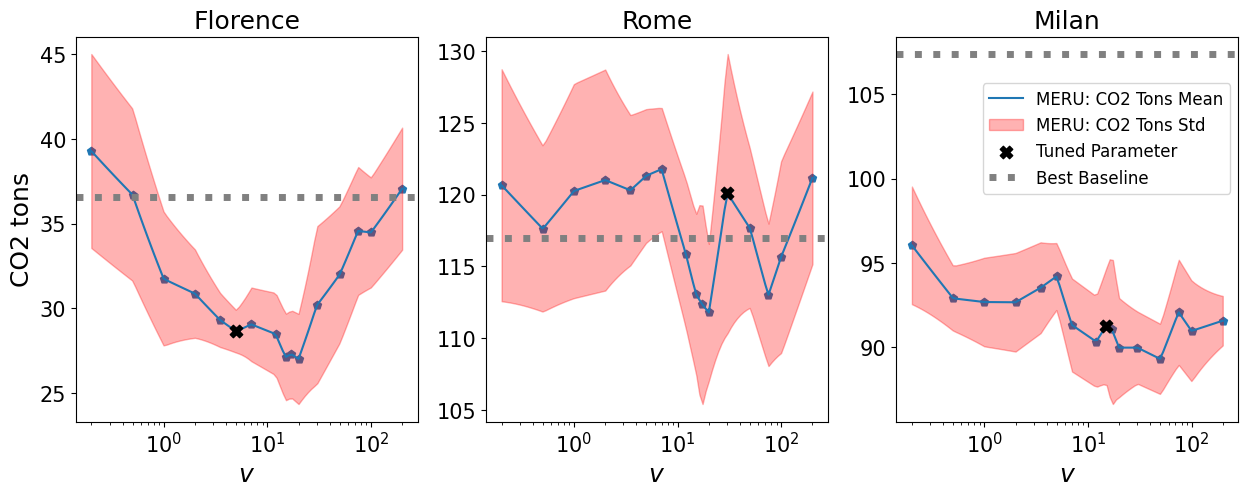

In [15]:
# Create a figure with 3 subplots
plt.figure(figsize=(15, 5))
print('Reduction in CO2 (mean) (std)')

for n, city in enumerate(['florence', 'rome', 'milan_big']):
    plt.subplot(1, 3, n+1)  # 1 row, 3 columns, ith plot
    
    if n == 0:
        plt.ylabel('CO2 tons', fontsize = 18)
    
    log = True

    fitted_vehicles = chosen_map[city]
    
    results_dist = {}
    results_dist['measures'] = pd.read_csv(f'{output_folder}{city}/{city}_distributions_simulation_results.csv')

    df = pd.read_csv(f'{output_folder}/{city}/simulation_results.csv')
    meru_records = df['algorithm_name'].str.contains('MERU')
    seru_records = df['algorithm_name'].str.contains('SERU')
    
    without_eru = df[~meru_records & ~seru_records]
    grouped_avg = without_eru.groupby('algorithm_name')['CO2 Tons'].mean()

    # Find the value of A with the lowest average value of CO2 Tons
    best_baseline = grouped_avg.idxmin()
    
    print(city, 'best baseline is', best_baseline, end = ' : \t')
    res = df[df['algorithm_name'] == best_baseline]
    print(f"CO2 AVG = {res['CO2 Tons'].mean():.2f}",
          f"CO2 STD = {res['CO2 Tons'].std():.2f}")
    
    
    df_algo = results_dist['measures'][results_dist['measures']['algorithm_name'].str.contains('MERU')]
    df_algo['fitted_vehicles'] = df_algo['algorithm_name'].str.replace('MERU', '').astype(int)
    sorted_df = df_algo.sort_values(by=['fitted_vehicles', 'random_state'], ascending=[True, True])
    
    plot_co2_meru(sorted_df, log_scale=log)
    parameter_fitting_result_co2 = sorted_df[sorted_df['fitted_vehicles'] == fitted_vehicles]['CO2 Tons']
    
    print(city, 'use case is', f'MERU{fitted_vehicles}', end = ' : \t\t')
    print(f'CO2 AVG = {parameter_fitting_result_co2.mean():.2f}', 
          f'CO2 STD = {parameter_fitting_result_co2.std():.2f}')
    
    usecase_delta = (res['CO2 Tons'].mean() - parameter_fitting_result_co2.mean()) / res['CO2 Tons'].mean()
    print('Usecase improvement', city+'\t' if city == 'rome' else city, f'{round(usecase_delta*100, 2)}%', sep = '\t')
    
    plt.scatter([fitted_vehicles / 1000], parameter_fitting_result_co2.mean(), marker = 'X', s = 80, color = 'black', label = f'Tuned Parameter', zorder = 10)

    plt.axhline(y=res['CO2 Tons'].mean(), linewidth=5, linestyle='dotted', color='gray', label='Best Baseline')
    plt.title(f'{city[0].upper()}{city[1:].replace("_big", "")}', fontsize = 18)
    plt.xlabel('$v$', fontsize = 18)
    plt.xticks(fontsize = 15)
    plt.yticks(fontsize = 15)
    mean_x = round(((res['CO2 Tons'].mean() - df_algo['CO2 Tons']) / res['CO2 Tons'].mean()).mean(), 2)
    std_x = round(((res['CO2 Tons'].mean() - df_algo['CO2 Tons']) / res['CO2 Tons'].mean()).std(), 2)
    
    print('Average improvement:', city+'\t' if city == 'rome' else city, mean_x, std_x, sep = '\t')

# plt.suptitle(f'CO2 Tons w/ different parameters on cities', fontsize = 18)
# Place the legend outside the plot
plt.legend(loc='upper right', bbox_to_anchor=(1, 0.9), fontsize = 12)

# Show the plot
plt.show()


# Get Computation Time

In [17]:
from meru import MultiLevelModel, BaselineModel
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import numpy as np
import time

attribute = 'traveltime'
random_state = 0
tests = 1000
k = 3

algorithm_parameters = {'NR' : {},
                        'KSP' : {},
                        'KD'  : {},
                        'PP'  : {'p' : 0.2},
                        'KMD' : {'epsilon' : 0.3},
                        'GR'  : {'delta' : 0.2, 'tau' : 0.2},
                        'KML' : {'theta' : 0.8},
                        'PLAT': {'epsilon' : 1.3}}

# SINCE THEY CAN BE EXTRACTED I MAPPED THEM, IT'S FASTER THAN EXTRACTING THEM
chosen_map = {'florence' : 5000,
              'milan_big' : 15000,
              'rome' : 30000}

In [18]:
def init_network(root, city):
    road_network_path = f'{root}/pattern-optimized-routes/data/{city}_road_network.net.xml'
    mobility_demand_path = f'{root}/pattern-optimized-routes/data/dict_mobility_demand_{city}.json'

    road_network = sumolib.net.readNet(road_network_path, withInternal=False)
    G = from_sumo_to_igraph_network(road_network)
    return road_network, G

def load_meru_model(G, k, attribute, random_state, fit_vehicle):
    meru = MultiLevelModel(G, k, attribute)
    meru.parameter_selection(n_vehicles = fit_vehicle, random_state = random_state)
    meru.fit(random_state = random_state)
    
    return meru

def generate_random_edges(tests, random_state):
    np.random.seed(random_state)
    seed_set = set()

    while len(seed_set) < tests:
        seed_set.add(np.random.randint(1, 999999))

    seeds = iter(seed_set)
    edges = []

    for _ in range(tests):
        np.random.seed(next(seeds))
        from_edge = np.random.choice(road_network.getEdges()).getID()
        to_edge = np.random.choice(road_network.getEdges()).getID()
        edges.append((from_edge, to_edge))
        
    return edges

def compute_algo_time(meru_model, algorithm_parameters):

    time_results = {x : [] for x in algorithm_parameters}
    time_results.update({'MERU' : [], 'SERU' : []})

    for pair in tqdm(edges):
        start = time.process_time()
        meru_result = meru_model.predict(*pair, k = k, multilevel = True)
        time_results['MERU'].append(time.process_time() - start)

        start = time.process_time()
        seru_result = meru_model.predict(*pair, k = k, multilevel = False)
        time_results['SERU'].append(time.process_time() - start)

        for key in algorithm_parameters:
            start = time.process_time()
            bm = BaselineModel(key, G, k, attribute, **algorithm_parameters[key])
            bm.predict(*pair)
            time_results[key].append(time.process_time() - start)
            
    return time_results

/home/llemma/.local/lib/python3.8/site-packages/skmob/tessellation/tilers.py:117: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  base_shape = gpd.GeoSeries(cascaded_union(polygons), crs=base_shape.crs)


100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:07<00:00, 701.69it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [49:39<00:00,  2.98s/it]


100%|█████████████████████████████████████████████████████████████████████████████| 30000/30000 [05:10<00:00, 96.53it/s]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [6:35:37<00:00, 23.74s/it]


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [01:46<00:00, 141.05it/s]


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [5:10:44<00:00, 18.64s/it]


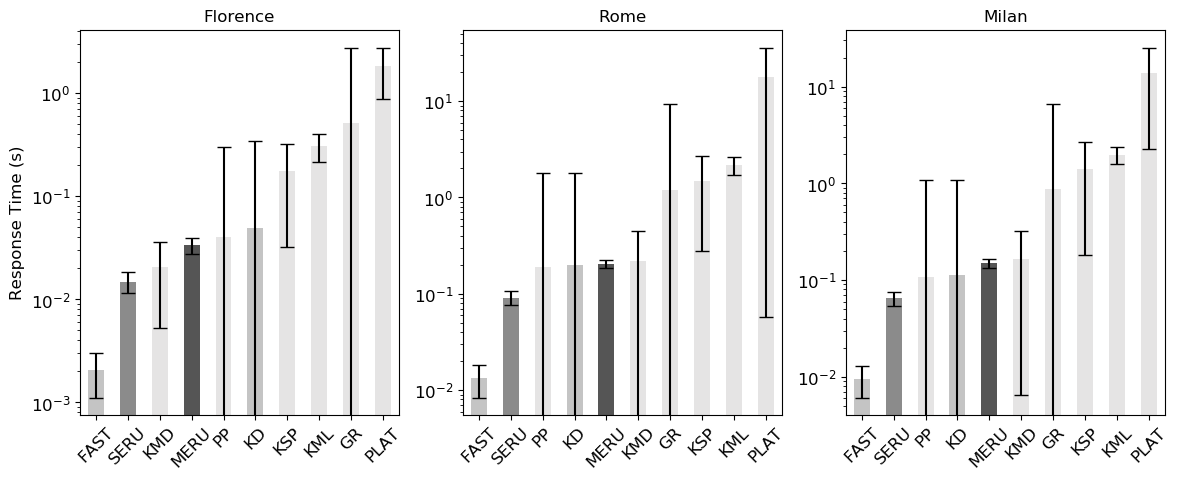

In [19]:
fig, axes = plt.subplots(1, 3, figsize=(14, 5))  # Width: 12 inches, Height: 4 inches
# Flatten the axes list for easy indexing
axes = axes.flatten()

for idx, city in enumerate(['florence', 'rome', 'milan_big']):
    road_network, G = init_network(root, city)
    meru_model = load_meru_model(G, k, attribute, random_state, chosen_map[city])
    
    edges = generate_random_edges(tests, random_state)
    time_results = compute_algo_time(meru_model, algorithm_parameters)
    
    ax = axes[idx]
    
    df = pd.DataFrame(time_results).mean().sort_values()

    colors_map = {}

    for x in df.index:
        if x == 'NR' or x == 'KD':
            colors_map[x] = '#ababab'
        elif 'SERU' in x:
            colors_map[x] = '#5A5A5A'
        elif 'MERU' in x:
            colors_map[x] = '#0d0d0d'
        else:
            colors_map[x] = '#dbd9d9'

    colors = list(colors_map.values())

    std_devs = pd.DataFrame(time_results)[df.index].std().values
    df.plot(kind = 'bar', yerr=std_devs, capsize=5, align='center', alpha=0.7, color = colors, ax = ax)


    ax.set_xticks(ax.get_xticks())
    names = list(df.index)
    names[names.index('NR')] = 'FAST'
    ax.set_xticklabels(names, fontsize = 12, rotation=45)
    ax.set_yticklabels(ax.get_yticks(), fontsize = 12)
    ax.set_title(city[0].upper()+city[1:].replace('_big', ''))
    if idx == 0:
        ax.set_ylabel('Response Time (s)', fontsize = 12)

    # Log-transform the y-axis
    ax.set_yscale('log')
    
backup_axes = axes

In [228]:
from matplotlib.patches import Rectangle

bars = [list(zip([x.get_text() for x in ax.get_xticklabels()], [x.get_height() for x in ax.get_children() if type(x) is Rectangle])) for ax in axes]
bars = [np.array(x) for x in bars]

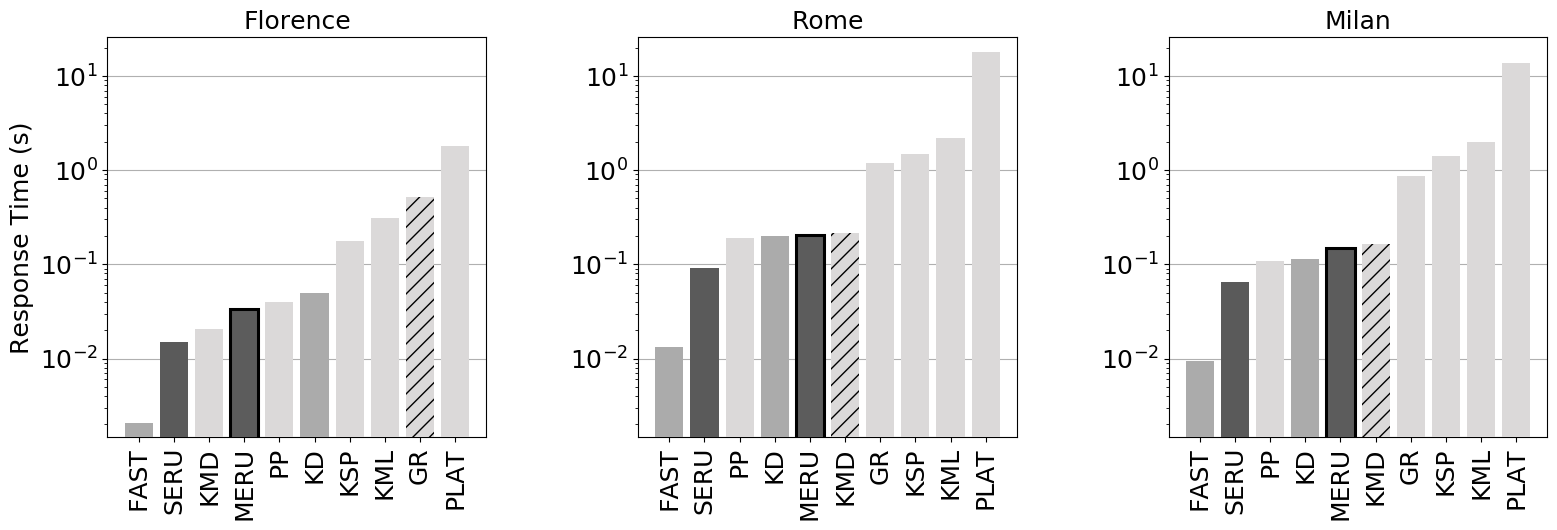

In [256]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))  # Width: 18 inches, Height: 5 inches
# Flatten the axes list for easy indexing
axes = axes.flatten()

best_baselines = {'florence' : 'GR', 'rome' : 'KMD', 'milan_big' : 'KMD'}
fsize = 18

for idx, city in enumerate(['florence', 'rome', 'milan_big']):
    
    ax = axes[idx]
    
    df = pd.DataFrame(bars[idx][:,1], index = bars[idx][:,0], columns = ['data'])['data'].astype(float)
    
    colors_map = {}

    for x in df.index:
        if x == 'FAST' or x == 'KD':
            colors_map[x] = '#ababab'
        elif 'SERU' in x:
            colors_map[x] = '#5A5A5A'
        elif 'MERU' in x:
            colors_map[x] = '#5c5c5c'
        else:
            colors_map[x] = '#dbd9d9'

    colors = list(colors_map.values())
    
    ax.bar(df.index, df.values, ecolor='black', color = colors, zorder = 100, width = 0.8)

    ax.bar(list(df.index).index('MERU'), df['MERU'], edgecolor='black', color = '#5c5c5c', linewidth=2.2, zorder = 200, width = 0.8)
    ax.bar(list(df.index).index(best_baselines[city]), df[best_baselines[city]], color = '#dbd9d9', hatch = '//', linewidth=2.2, zorder = 200, width = 0.8)


    ax.set_xticks(ax.get_xticks())
    names = list(df.index)
    ax.set_xticklabels(names, fontsize = 12, rotation=45)
    ax.set_yticklabels(ax.get_yticks(), fontsize = 12)
    ax.set_title(city[0].upper()+city[1:].replace('_big', ''))

    
    ax.grid(axis='y', which='major', zorder = 0)
    ax.set_title(city[0].upper()+city[1:].replace('_big', ''), fontsize = fsize)

    ax.tick_params(axis='both', which='both', labelsize=fsize)
    ax.tick_params(axis='x', which='both', labelsize=fsize, rotation = 90)
        

    plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.4, hspace=0.4)

    if idx == 0:
        ax.set_ylabel('Response Time (s)', fontsize = fsize)

    # Log-transform the y-axis
    ax.set_yscale('log')

mint = min([ax.get_ylim()[0] for ax in axes])
maxt = max([ax.get_ylim()[-1] for ax in axes])
[ax.set_ylim(mint, maxt) for ax in axes]
plt.show()

# GET MEASURES

In [355]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib

# SINCE THEY CAN BE EXTRACTED I MAPPED THEM, IT'S FASTER THAN EXTRACTING THEM
chosen_map = {'florence' : 5000,
              'milan_big' : 15000,
              'rome' : 30000}

cols = { 'CO2 Tons': 'CO2 Tons',
         'N Teleports': 'Number of Collisions',
         'Total Redundancy': 'Total Redundancy',
         'N Traveled Edges': 'Number of Traveled Edges',
         'Avg Diversity of Suggestions': 'Average Diversity of Suggestions',
         'Road Coverage': 'Road Coverage',
         'Entropy': 'Total Entropy',
         'Vehicles Traveltime': 'Simulation Vehicles Traveltime',
         'Avg Traveled Edge Traveltime': 'Average Edge Traversal time',
         'Avg Traveled Path Traveltime': 'Average Path Travel-time'}

best_baselines = {'florence' : 'GR', 'rome' : 'KMD', 'milan_big' : 'KMD'}

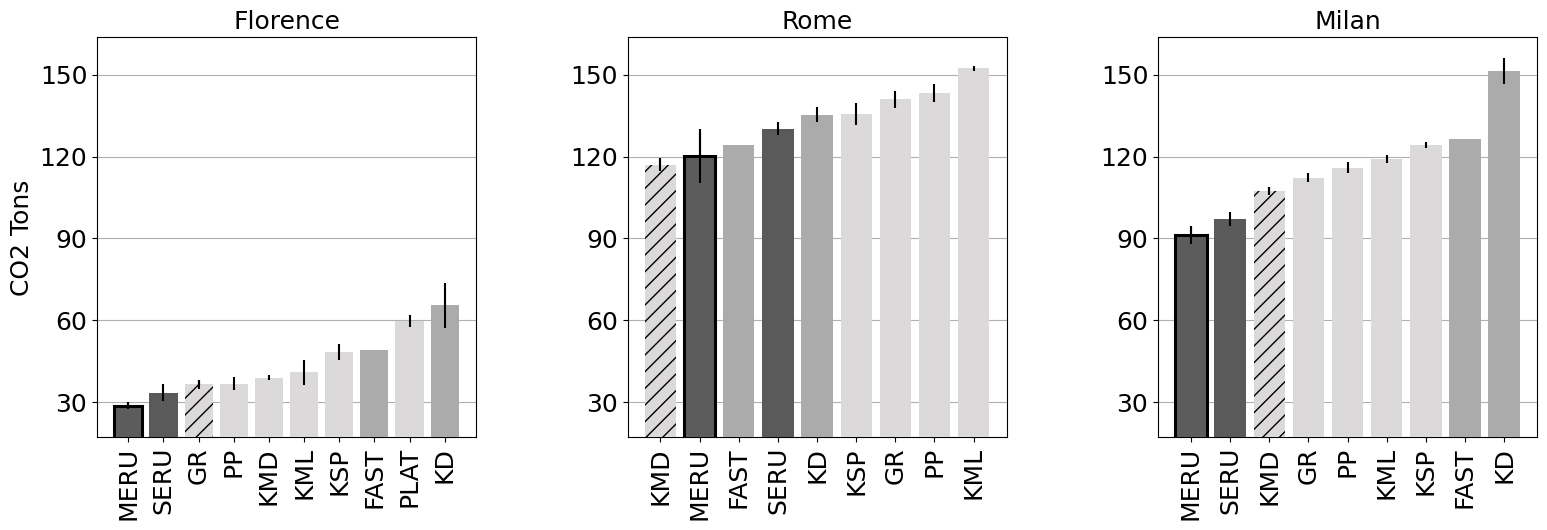

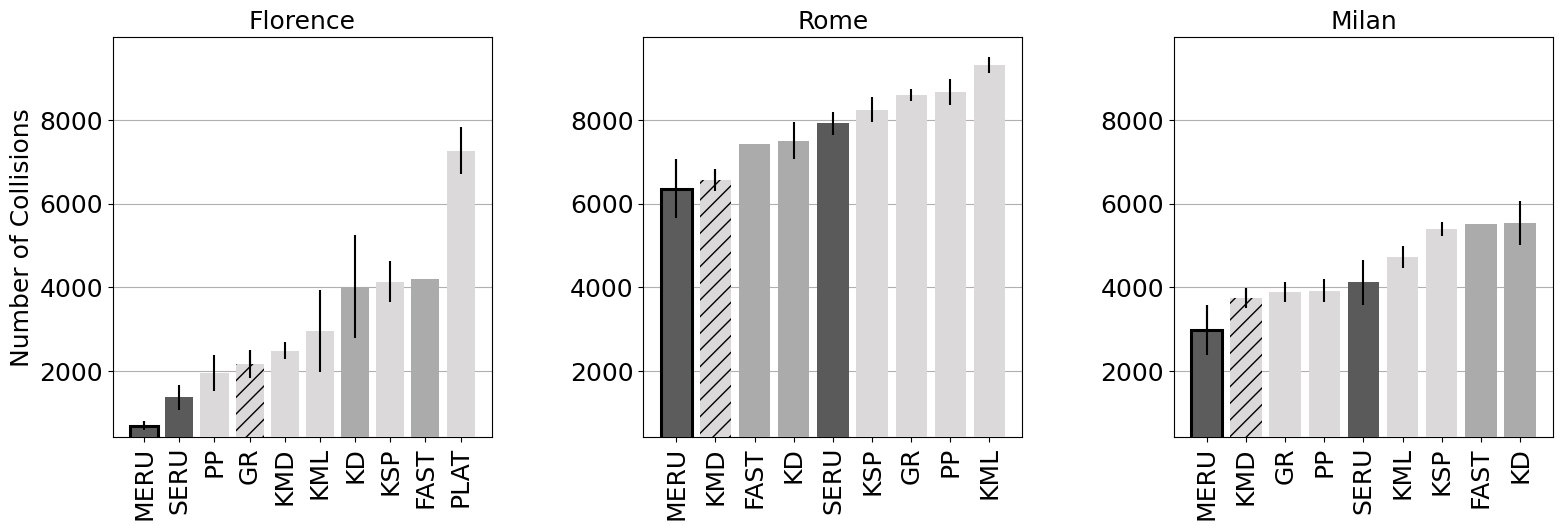

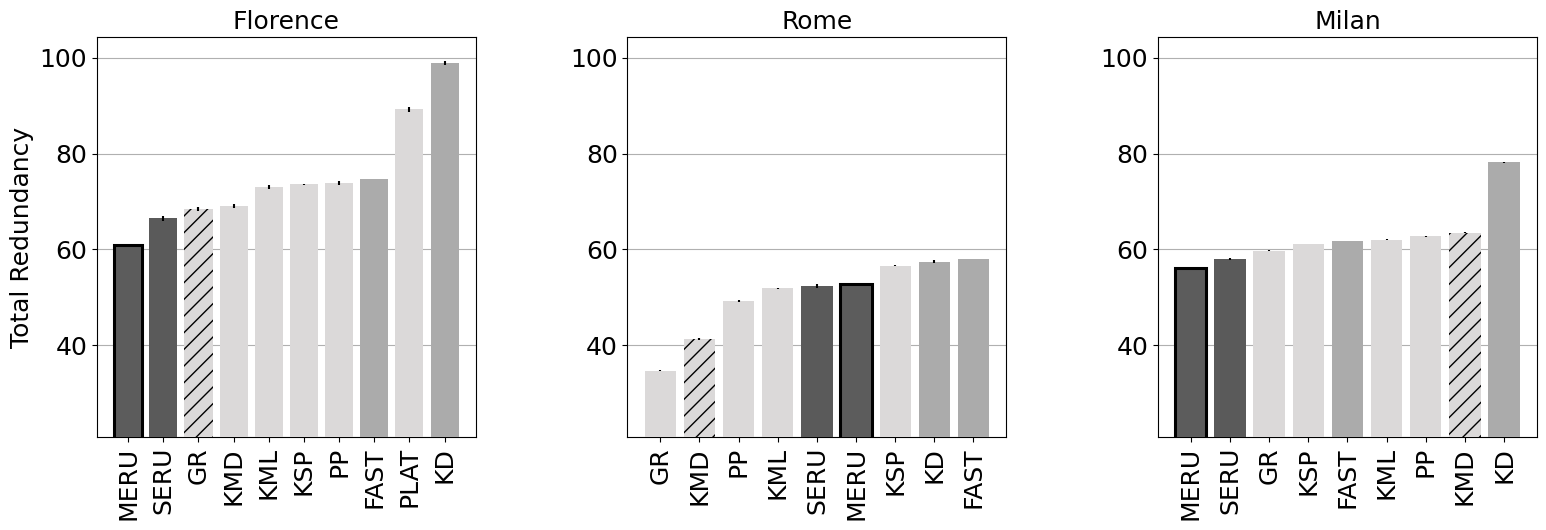

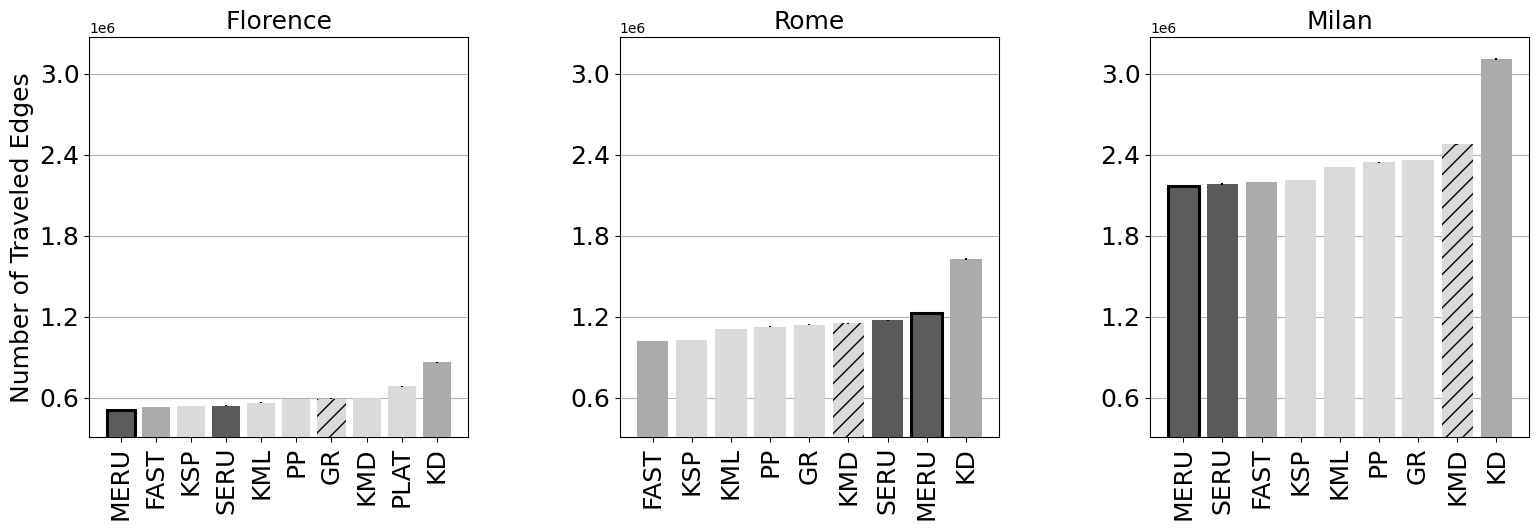

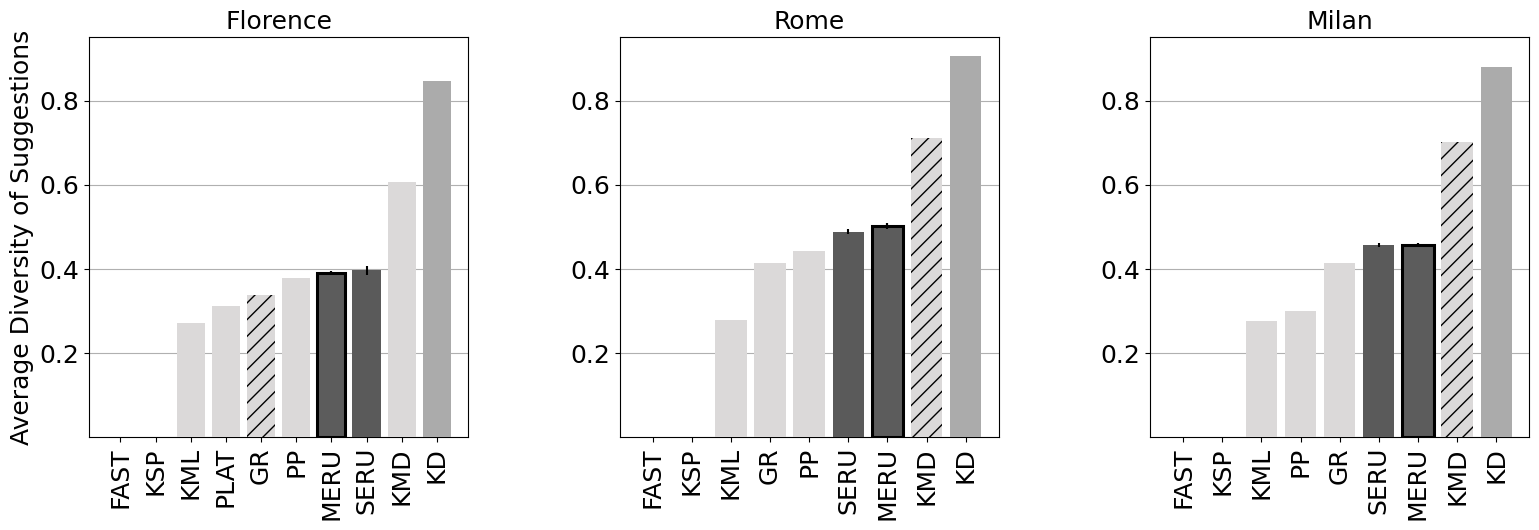

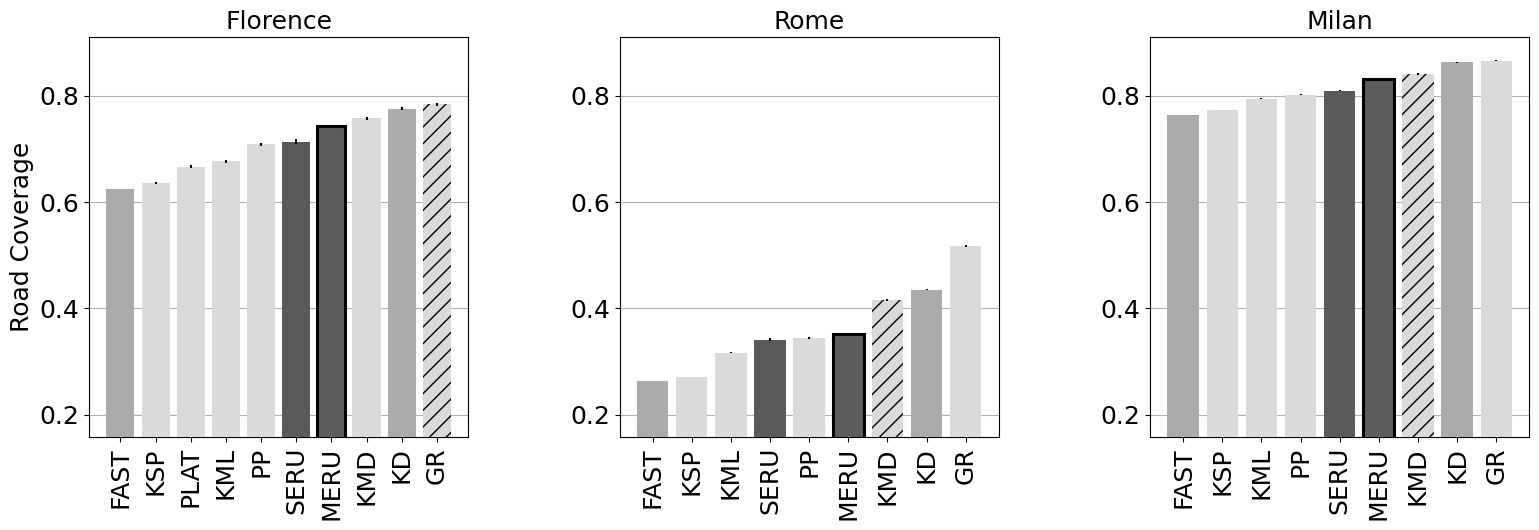

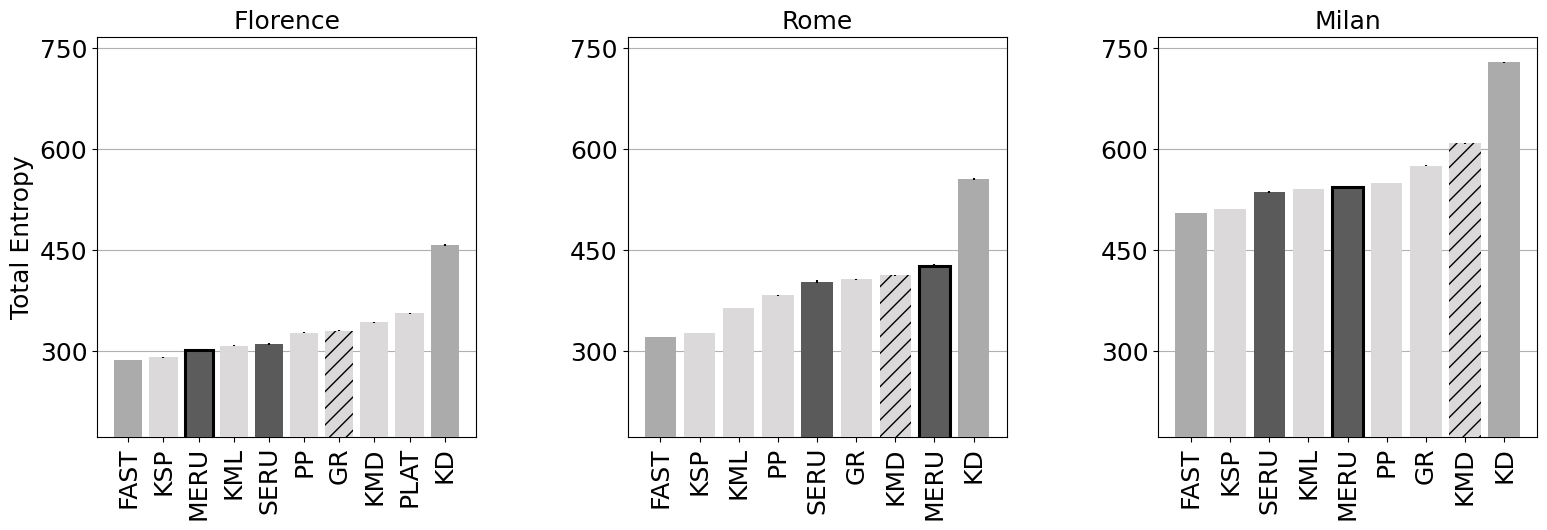

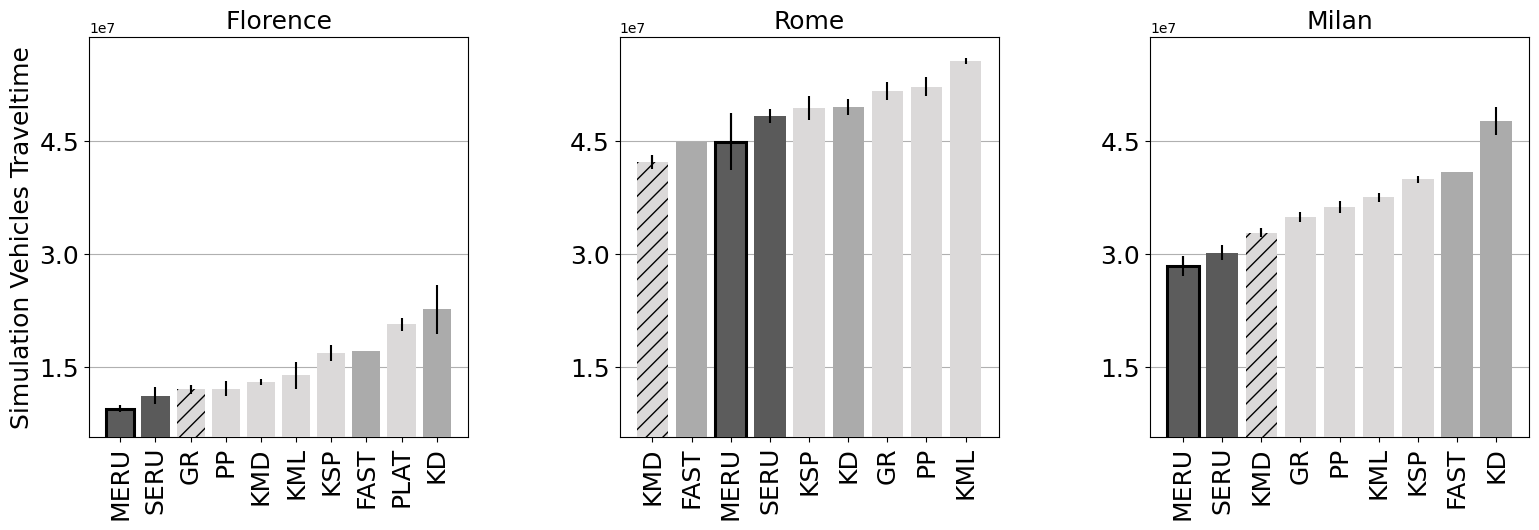

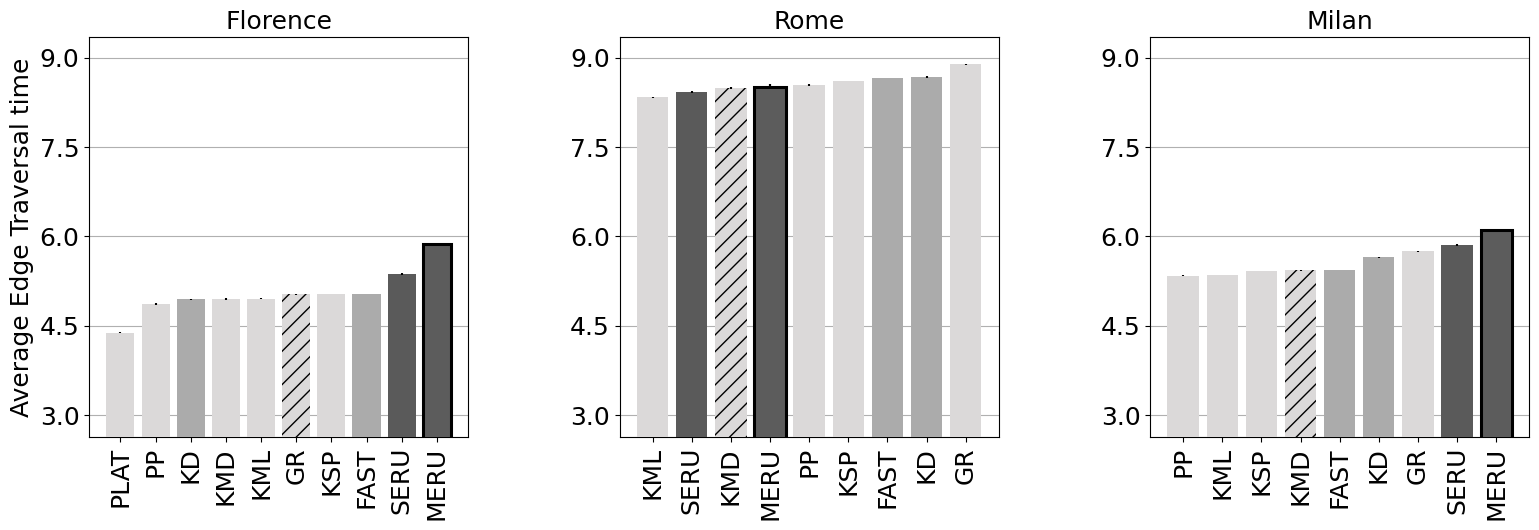

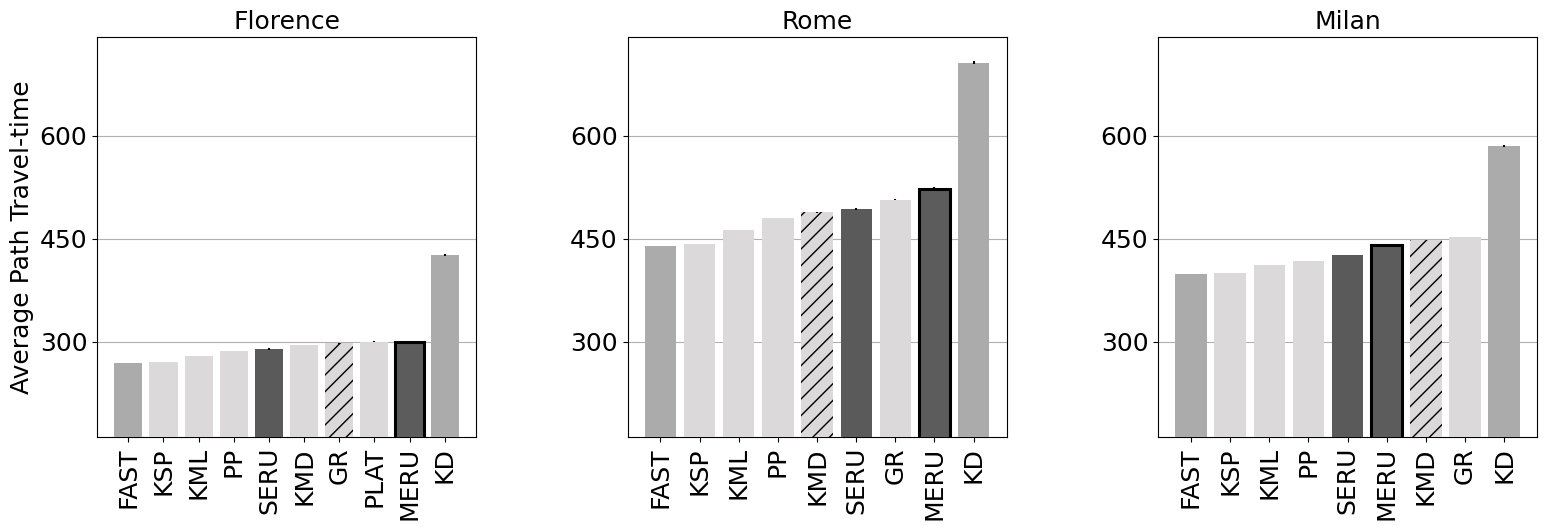

In [356]:
for col in cols:
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))  # Width: 18 inches, Height: 5 inches
    # Flatten the axes list for easy indexing
    axes = axes.flatten()
    fsize = 18
    
    for idx, city in enumerate(['florence', 'rome', 'milan_big']):

        ax = axes[idx]

        df_source = pd.read_csv(f'{output_folder}/{city}/simulation_results.csv')

        to_plot = df_source['CO2 Tons'].groupby(df_source['algorithm_name']).mean()
        to_plot = pd.DataFrame(to_plot).reset_index()
        to_plot['algorithm_prefix'] = to_plot['algorithm_name'].str.split('_').str[0]

        # Find the rows with the lowest CO2 Tons for each algorithm prefix
        result_df = to_plot.groupby('algorithm_prefix').apply(lambda x: x[x['CO2 Tons'] == x['CO2 Tons'].min()])
        # Reset index to clean up the DataFrame
        result_df = result_df.reset_index(drop=True)
        # Drop the algorithm_prefix column if you don't need it anymore
        result_df = result_df.drop(columns=['algorithm_prefix'])

        lowest_CO2_ls = result_df['algorithm_name'].tolist()

        CO2_df = df_source[df_source['algorithm_name'].isin(lowest_CO2_ls)]

        measure_df = CO2_df.groupby('algorithm_name')[col]
        std_series = measure_df.std()
        mean_series = measure_df.mean().fillna(0)
        mean_series.index = [x.split('_')[0]\
                             .replace('NR', 'FAST')\
                             .replace(f'MERU{chosen_map[city]}', 'MERU')\
                             .replace(f'SERU{chosen_map[city]}', 'SERU')\
                             for x in mean_series.index]
        
        std_series.index = mean_series.index
        mean_series = mean_series.sort_values()

        colors_map = {}

        for x in mean_series.index:
            if x == 'FAST' or x == 'KD':
                colors_map[x] = '#ababab'
            elif 'SERU' in x:
                colors_map[x] = '#5A5A5A'
            elif 'MERU' in x:
                colors_map[x] = '#5c5c5c'
            else:
                colors_map[x] = '#dbd9d9'

        colors = list(colors_map.values())
        
        yerr = std_series.reindex(mean_series.index)
        
        #mean_series.plot(kind = 'bar', yerr = yerr, ecolor='black', capsize=5, align='center', alpha=1, color = colors, ax = ax, zorder = 100, width=0.5)
        ax.bar(mean_series.index, mean_series.values, yerr = yerr, ecolor='black', color = colors, zorder = 100, width = 0.8)

        ax.bar(list(mean_series.index).index('MERU'), mean_series['MERU'], yerr = yerr['MERU'], ecolor='black', edgecolor='black', color = '#5c5c5c', linewidth=2.2, zorder = 200, width = 0.8)
        ax.bar(list(mean_series.index).index(best_baselines[city]), mean_series[best_baselines[city]], yerr = yerr[best_baselines[city]], ecolor='black', color = '#dbd9d9', hatch = '//', linewidth=2.2, zorder = 200, width = 0.8)


        ax.grid(axis='y', which='both', zorder = 0)
        ax.set_title(city[0].upper()+city[1:].replace('_big', ''), fontsize = fsize)
        
        if idx == 0:
            ax.set_ylabel(cols[col], fontsize = fsize)
        
        ax.set_ylim(mean_series.min()*0.6)
        ax.yaxis.set_major_locator(matplotlib.ticker.MaxNLocator(prune='both', nbins = 5))

        ax.tick_params(axis='both', which='both', labelsize=fsize)
        ax.tick_params(axis='x', which='both', labelsize=fsize, rotation = 90)
        
    mint = min([ax.get_ylim()[0] for ax in axes])
    maxt = max([ax.get_ylim()[-1] for ax in axes])
    [ax.set_ylim(mint, maxt) for ax in axes]
    [ax.yaxis.set_major_locator(matplotlib.ticker.MaxNLocator(prune='both', nbins = 5)) for ax in axes]


    plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.4, hspace=0.4)

    plt.show()

# NORMALIZED ENTROPY

['GR_delta02_tau02', 'KD', 'KMD_epsilon03', 'KML_theta08', 'KSP', 'MERU5000', 'NR', 'PLAT_epsilon13', 'PP_p02', 'SERU5000']
['GR_delta02_tau02', 'KD', 'KMD_epsilon03', 'KML_theta08', 'KSP', 'MERU30000', 'NR', 'PP_p02', 'SERU30000']
['GR_delta02_tau02', 'KD', 'KMD_epsilon03', 'KML_theta08', 'KSP', 'MERU15000', 'NR', 'PP_p005', 'SERU15000']


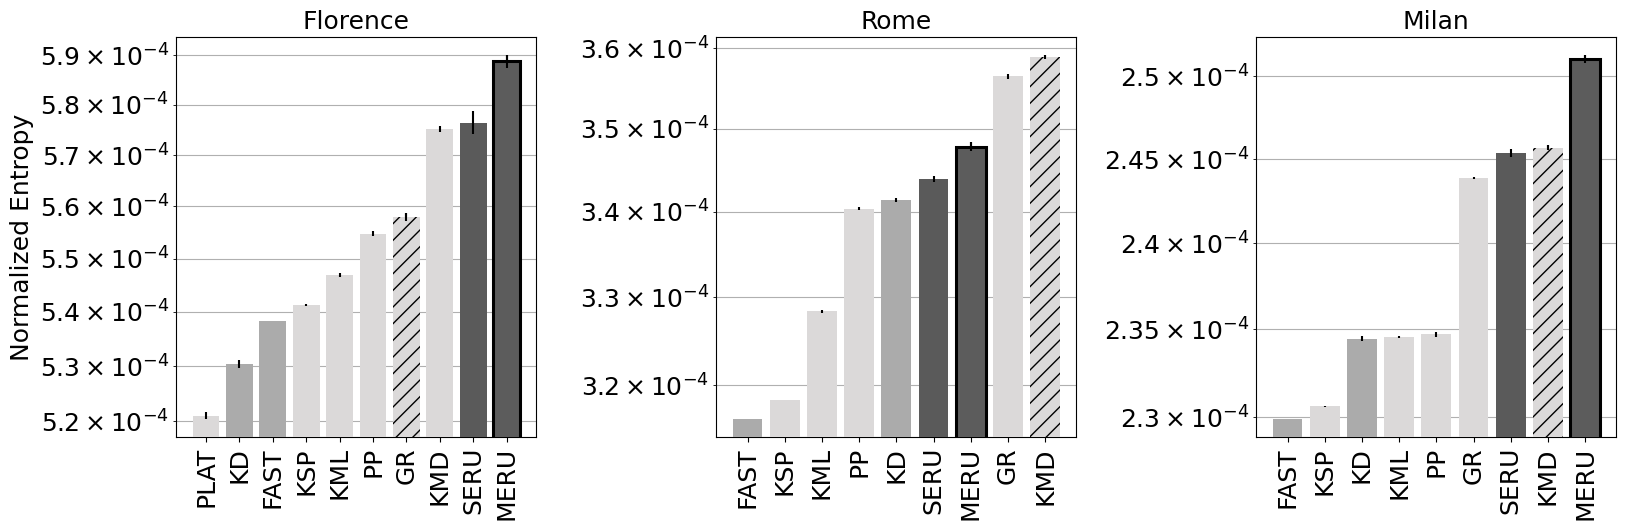

In [357]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))  # Width: 12 inches, Height: 4 inches
# Flatten the axes list for easy indexing
axes = axes.flatten()

for idx, city in enumerate(['florence', 'rome', 'milan_big']):
    
    ax = axes[idx]
    
    df_source = pd.read_csv(f'{output_folder}/{city}/simulation_results.csv')

    to_plot = df_source['CO2 Tons'].groupby(df_source['algorithm_name']).mean()
    to_plot = pd.DataFrame(to_plot).reset_index()
    to_plot['algorithm_prefix'] = to_plot['algorithm_name'].str.split('_').str[0]

    # Find the rows with the lowest CO2 Tons for each algorithm prefix
    result_df = to_plot.groupby('algorithm_prefix').apply(lambda x: x[x['CO2 Tons'] == x['CO2 Tons'].min()])
    # Reset index to clean up the DataFrame
    result_df = result_df.reset_index(drop=True)
    # Drop the algorithm_prefix column if you don't need it anymore
    result_df = result_df.drop(columns=['algorithm_prefix'])

    lowest_CO2_ls = result_df['algorithm_name'].tolist()
    print(lowest_CO2_ls)
    
    CO2_df = pd.DataFrame(df_source[df_source['algorithm_name'].isin(lowest_CO2_ls)])
    CO2_df['Normalized Entropy'] = CO2_df['Entropy'] / CO2_df['N Traveled Edges']

    measure_df = CO2_df.groupby('algorithm_name')['Normalized Entropy']
    std_series = measure_df.std()
    mean_series = measure_df.mean().fillna(0)
    mean_series.index = [x.split('_')[0]\
                         .replace('NR', 'FAST')\
                         .replace(f'MERU{chosen_map[city]}', 'MERU')\
                         .replace(f'SERU{chosen_map[city]}', 'SERU')\
                         for x in mean_series.index]

    std_series.index = mean_series.index
    mean_series = mean_series.sort_values()

    colors_map = {}

    for x in mean_series.index:
        if x == 'FAST' or x == 'KD':
            colors_map[x] = '#ababab'
        elif 'SERU' in x:
            colors_map[x] = '#5A5A5A'
        elif 'MERU' in x:
            colors_map[x] = '#5c5c5c'
        else:
            colors_map[x] = '#dbd9d9'

    colors = list(colors_map.values())

    yerr = std_series.reindex(mean_series.index)

    #mean_series.plot(kind = 'bar', yerr = yerr, ecolor='black', capsize=5, align='center', alpha=1, color = colors, ax = ax, zorder = 100, width=0.5)
    ax.bar(mean_series.index, mean_series.values, yerr = yerr, ecolor='black', color = colors, zorder = 100, width = 0.8)

    ax.bar(list(mean_series.index).index('MERU'), mean_series['MERU'], yerr = yerr['MERU'], ecolor='black', edgecolor='black', color = '#5c5c5c', linewidth=2.2, zorder = 200, width = 0.8)
    ax.bar(list(mean_series.index).index(best_baselines[city]), mean_series[best_baselines[city]], yerr = yerr[best_baselines[city]], ecolor='black', color = '#dbd9d9', hatch = '//', linewidth=2.2, zorder = 200, width = 0.8)


    ax.grid(axis='y', which='both', zorder = 0)
    ax.set_title(city[0].upper()+city[1:].replace('_big', ''), fontsize = fsize)

    if idx == 0:
        ax.set_ylabel('Normalized Entropy', fontsize = fsize)

    ax.tick_params(axis='both', which='both', labelsize=fsize)
    ax.tick_params(axis='x', which='both', labelsize=fsize, rotation = 90)
    
    ax.set_yscale('log')


plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.5, hspace=0.4)

plt.show()